# BikeMi Data

In [3]:
# path manipulation
from pathlib import Path

# data manipulation
import numpy as np
import pandas as pd
import geopandas

# plotting
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

# connecting to the local database with the data
import psycopg2

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# set settings for seaborn
sns.set_style(style="whitegrid", rc={"grid.color": ".9"})
sns.set_palette(palette="deep")

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
title_font = {"fontname": "DejaVu Sans Mono"}

# create paths
milan_data = Path("../data/milan")

# establish connection with the database
conn = psycopg2.connect("dbname=bikemi user=luca")

## Data Ingestion

The data was made available thanks to a partnership established by Prof. Giancarlo Manzi of the University of Milan and Clear Channel Italia, the provider of the service. The data is comprised of all the individual trips performed by each client (`cliente_anonimizzato`). This includes the bike type (which can either be a regular bike or an electric bike), the bike identifier, the station of departure and arrival with the time, the duration of the trip `durata_noleggio` plus the total travel distance. We do not know how the total travel distance `distanza_totale` is computed. Here are a selection of fields for the first five rows of the source data (time features are rounded to the daily level to fit into the page):

In [2]:
def show_data_sample(connection) -> pd.DataFrame:
    query = """
        SELECT
            bici,
            tipo_bici,
            cliente_anonimizzato,
            DATE_TRUNC('day', data_prelievo)::date AS giorno_prelievo,
            nome_stazione_prelievo,
            DATE_TRUNC('day', data_restituzione)::date AS giorno_restituzione,
            nome_stazione_restituzione
        FROM bikemi_source_data
        LIMIT 5;
    """

    return pd.read_sql(query, connection)


show_data_sample(conn)

bici tipo_bici  cliente_anonimizzato giorno_prelievo  \
0   8480      Bike                 47869      2015-07-01   
1   6190      Bike                 74372      2015-07-01   
2   6000      Bike                105372      2015-07-01   
3  10538     eBike                103840      2015-07-01   
4   1981      Bike                 57260      2015-07-01   

       nome_stazione_prelievo giorno_restituzione nome_stazione_restituzione  
0  Arco della Pace 2 - Pagano          2015-07-01       Vercelli - Cherubini  
1                  XXV Aprile          2015-07-01                    Caiazzo  
2                 San Giorgio          2015-07-01                    Rosario  
3                  XXV Aprile          2015-07-01                    Caiazzo  
4                  XXV Aprile          2015-07-01              Sant'Ambrogio

The data available ranges from the first of June, 2015, to the first of October, 2020, totalling to 15.842.891 observations. Data was made available in Excel spreadsheets, following the [Office Open XML SpreadsheetML File Format](https://docs.microsoft.com/en-us/openspecs/office_standards/ms-xlsx/f780b2d6-8252-4074-9fe3-5d7bc4830968) (the `.xlsx` file format). Python"s Pandas library has methods to read `.xlsx` files; however, given how big these files are, data manipulation would have proven unfeasible.

For this reason, we resorted to some useful and popular open source tools, which we used to build `bash` scripts and functions to automate conversion from `.xlsx` to `.csv` files, perform some elementary data cleaning and load the data into a local PostgreSQL database. Format conversion to Comma-Separated Values (`.csv`) was performed using [`csvkit`](https://github.com/wireservice/csvkit), a Python package to perform basic operations on `.csv` files from the command line. Being written in Python, `csvkit` can be slow. However, as part of a major trend for several command-line applications, `csvkit` was rewritten in Rust, a fast and secure programming language whose popularity has been rising in the last couple of years <cite id="jf5wt">(Perkel, 2020)</cite>. Much alike Julia <cite id="ge16g">(Perkel, 2019)</cite>, Rust is becoming a tool for data science, as well as scientific computing (for example in bio-statistics) as it is "a language that offer[s] the "expressiveness" of Python but the speed of languages such as C and C++" <cite id="1xb31">(Perkel, 2020)</cite>.

The Rust port of `csvkit` is called [`xsv`](https://github.com/BurntSushi/xsv), and is blazing fast. Much alike `awk` <cite id="tcloo">(<i>Gawk - GNU Project - Free Software Foundation (FSF)</i>, n.d.)</cite>, `xsv` can perform filtering operations, but also joins and partitions, as well as computing summary statistics. `xsv` does not offer format conversion (yet), but was used to filter out a negligible number of invalid observations from each original `.xslx` files (after the conversion to `.csv`), and select only the columns that would enter the final dataset.

Finally, `psql` (PostgreSQL"s command line utility) was used to upload the "clean" data into a local database instance. PostgreSQL was also used to perform basic survey statistics, like computing the number of rows, and data aggregation (such as counting the number of observations by year). Looking at the frequency tables by year, there appears to be an oddly small number of observations from 2018. This is because there is indeed missing data from June 2018 until the end of the year. For this reason, we chose to work only with data from June 2015 to the end of May 2018.

In [3]:
def count_users_by_year(connection) -> pd.DataFrame:
    query = """
        SELECT
            EXTRACT("year" FROM b.data_prelievo) AS date,
            COUNT(b.bici)
        FROM bikemi_source_data b
        GROUP BY EXTRACT("year" FROM b.data_prelievo);
    """

    return pd.read_sql(query, connection).astype("int").set_index("date")


count_users_by_year(conn)

count
date         
2015  1971891
2016  4066783
2017  4272480
2018  1457631
2019  2830566
2020  1243540

## Data Analysis

In addition to selecting only trips from June 2015 to June 2018, we also disregard all rentals whose duration is smaller than one minute (around 4000) - as previously done in the literature <cite id="oz3v4">(Toro et al., 2020)</cite>. This leaves us with more than 11,7 million observations. We will temporarily store these in a [materialised view](https://www.postgresql.org/docs/current/sql-creatematerializedview.html), that we will drop at the end of the data analysis.

```python
def create_materialised_view(connection) -> None:

    query_rentals_before_2019: str = """
        CREATE MATERIALIZED VIEW IF NOT EXISTS bikemi_rentals.bikemi_rentals_before_2019 AS
        (
        SELECT b.bici,
               b.tipo_bici,
               b.cliente_anonimizzato,
               DATE_TRUNC('second', b.data_prelievo)     AS data_prelievo,
               b.numero_stazione_prelievo,
               b.nome_stazione_prelievo,
               DATE_TRUNC('second', b.data_restituzione) AS data_restituzione,
               b.numero_stazione_restituzione,
               b.nome_stazione_restituzione,
               b.durata_noleggio
        FROM bikemi_rentals.bikemi_source_data b
        WHERE EXTRACT(
                      'year'
                      FROM b.data_restituzione
                  ) < 2019
          AND durata_noleggio > interval '1 minute'
            );
    """

    with connection:
        with connection.cursor() as cursor:
            cursor.execute(query_rentals_before_2019)
```

The service has almost two-hundred thousands unique subscribers in the time period. For the years 2016 and 2017, the only ones for which we have complete data, the number of subscribers is almost a hundred thousand. By lookind at the unique subscribers for the other two years, it might seem that the number of subscribers in the second half of the year is higher.

In [4]:
def count_distinct_users(connection) -> pd.DataFrame:
    query = """
        SELECT
            COUNT(DISTINCT cliente_anonimizzato)
        FROM bikemi_rentals_before_2019;
        """

    return pd.read_sql(query, connection)


count_distinct_users(conn)

count
0  192431

In [5]:
def count_users_by_year(connection) -> pd.DataFrame:
    query = """
    SELECT
        EXTRACT("year" FROM data_prelievo) AS anno,
        COUNT(DISTINCT cliente_anonimizzato)
    FROM bikemi_rentals_before_2019
    GROUP BY EXTRACT("year" FROM data_prelievo);
    """
    return pd.read_sql(query, connection).astype({"anno": "int"}).set_index("anno")


count_users_by_year(conn)

count
anno       
2015  64079
2016  93239
2017  95931
2018  50860

It is also of interest to look at the number of rentals of each user, broken down by year. As expected, there are more observations from the years 2016 and 2017 as these are complete years. The great number of usage translates to an average of almost 4 trips per day - i.e., to reach the first train station and then the workplace.

In [6]:
def get_top_users_by_year(connection) -> pd.DataFrame:
    query = """
        SELECT
            cliente_anonimizzato,
            COUNT(*) AS noleggi_totali,
            EXTRACT("year" FROM data_prelievo) AS anno
        FROM bikemi_rentals_before_2019 b
        GROUP BY
            cliente_anonimizzato,
            EXTRACT("year" FROM data_prelievo)
        ORDER BY noleggi_totali DESC
        LIMIT 10;
    """

    return pd.read_sql(query, connection).astype({"anno": "int"}).set_index("cliente_anonimizzato")


get_top_users_by_year(conn)

noleggi_totali  anno
cliente_anonimizzato                      
43969                           1478  2017
146640                          1355  2017
40585                           1290  2017
40585                           1263  2016
188391                          1133  2017
165664                          1056  2016
147597                          1042  2016
19515                           1039  2017
97713                           1025  2017
90177                            988  2016

### Usage Patterns and Origin-Destination Matrix

As a starter, it is useful to look at the origin-destination (OD) matrix, to see which are the most popular starting and departure points. On the aggregate level, the most popular points on the OD matrix are the train stations and sightseeing places such as Duomo.

In [10]:
def get_top_stations(cols: list[str], connection, commuting_hours: bool = False) -> pd.DataFrame:
    def _top_stations(colname: str, _connection, commuting: bool = commuting_hours) -> pd.DataFrame:
        if commuting:
            query = f"""
            SELECT
                {colname} AS {colname.replace("nome_", "")},
                COUNT(*) AS numero_noleggi
            FROM bikemi_rentals_before_2019
            WHERE
                EXTRACT("dow" FROM data_restituzione) BETWEEN 0 AND 4 AND
                EXTRACT("hour" FROM data_restituzione) BETWEEN 7 AND 10 OR
                EXTRACT("hour" FROM data_restituzione) BETWEEN 17 AND 20
            GROUP BY
                f{colname}
            ORDER BY numero_noleggi DESC
            LIMIT 10;
            """

        query = f"""
            SELECT
                {colname} AS {colname.replace("nome_", "")},
                COUNT(*) AS numero_noleggi
            FROM bikemi_rentals_before_2019
            GROUP BY
                {colname}
            ORDER BY numero_noleggi DESC
            LIMIT 10;
        """
        return pd.read_sql(query, _connection)

    return pd.concat([_top_stations(col, connection) for col in cols], axis=1)


get_top_stations(["nome_stazione_prelievo", "nome_stazione_restituzione"], conn)

stazione_prelievo  numero_noleggi  stazione_restituzione  \
0              Cadorna 3          234694              Cadorna 3   
1                  Duomo          197573                  Duomo   
2                Moscova          139561                Moscova   
3     Garibaldi - Sturzo          134243     Garibaldi - Sturzo   
4  San Babila - RIMOSSA-          128261             XXV Aprile   
5             XXV Aprile          127804  San Babila - RIMOSSA-   
6              Cadorna 1          118692                Cairoli   
7                Cairoli          108717         Palazzo Marino   
8             Centrale 1          107864              Cadorna 1   
9      Coni Zugna Solari           99152                 Cavour   

   numero_noleggi  
0          234349  
1          202773  
2          140552  
3          129611  
4          129006  
5          127974  
6          113104  
7          103253  
8          102102  
9           98083

The ranking is basically unchanged if we look only at data from Monday to Friday and within "core" commuting hours (say, from 7 to 10 and from 17 to 20). However, trips towards stations become more frequent and destinations such as Moscova are slightly less popular. Indeed, employees might straight bike to Moscova after work to take a sip from their Negroni.

In [11]:
get_top_stations(["nome_stazione_prelievo", "nome_stazione_restituzione"], conn, commuting_hours=True)

stazione_prelievo  numero_noleggi  stazione_restituzione  \
0              Cadorna 3          234694              Cadorna 3   
1                  Duomo          197573                  Duomo   
2                Moscova          139561                Moscova   
3     Garibaldi - Sturzo          134243     Garibaldi - Sturzo   
4  San Babila - RIMOSSA-          128261             XXV Aprile   
5             XXV Aprile          127804  San Babila - RIMOSSA-   
6              Cadorna 1          118692                Cairoli   
7                Cairoli          108717         Palazzo Marino   
8             Centrale 1          107864              Cadorna 1   
9      Coni Zugna Solari           99152                 Cavour   

   numero_noleggi  
0          234349  
1          202773  
2          140552  
3          129611  
4          129006  
5          127974  
6          113104  
7          103253  
8          102102  
9           98083

The behaviour changes if we look ad the individual trips, i.e. if we `GROUP BY` both departure and destination stations (`nome_stazione_prelievo` and `nome_stazione_restituzione`). To be exact, `Coni Zugna Solari` is close to both the station in Porta Genova as well as the Navigli and Darsena, which partly explains its popularity.

In [12]:
def get_top_od(connection, commuting_hours: bool = False) -> pd.DataFrame:
    if commuting_hours:
        query = """
                SELECT
                    nome_stazione_prelievo AS stazione_prelievo,
                    nome_stazione_restituzione AS stazione_destinazione,
                    COUNT(*) AS numero_noleggi
                FROM bikemi_rentals_before_2019
                WHERE
                    EXTRACT("dow" FROM data_restituzione) BETWEEN 0 AND 4 AND
                    EXTRACT("hour" FROM data_restituzione) BETWEEN 7 AND 10 OR
                    EXTRACT("hour" FROM data_restituzione) BETWEEN 17 AND 20
                GROUP BY
                    nome_stazione_prelievo,
                    nome_stazione_restituzione
                ORDER BY numero_noleggi DESC
                LIMIT 10;
            """

    query = """
        SELECT
            nome_stazione_prelievo AS stazione_prelievo,
            nome_stazione_restituzione AS stazione_destinazione,
            COUNT(*) AS numero_noleggi
        FROM bikemi_rentals_before_2019
        GROUP BY
            nome_stazione_prelievo,
            nome_stazione_restituzione
        ORDER BY numero_noleggi DESC
        LIMIT 10;
    """

    return pd.read_sql(query, connection)


get_top_od(conn)

stazione_prelievo   stazione_destinazione  numero_noleggi
0    Coni Zugna Solari     Napoli - Washington           14144
1  Napoli - Washington       Coni Zugna Solari           13256
2            Cadorna 3                   Duomo            9363
3                Duomo               Cadorna 3            8903
4    Coni Zugna Solari        Savona - Tolstoj            8217
5       Palazzo Marino               Cadorna 3            7436
6           Bertarelli               Cadorna 3            6967
7  Vercelli - Piemonte  Roncaglia - Washington            6373
8                Piola       Gorini - Strambio            6336
9            Cadorna 3           Arcivescovado            6197

The same considerations apply when looking at the top trips only within the "core" commuting hours. This reinforces the conclusion that BikeMi is consistently used for commuting purposes.

In [13]:
get_top_od(conn, commuting_hours=True)

stazione_prelievo   stazione_destinazione  numero_noleggi
0    Coni Zugna Solari     Napoli - Washington           14144
1  Napoli - Washington       Coni Zugna Solari           13256
2            Cadorna 3                   Duomo            9363
3                Duomo               Cadorna 3            8903
4    Coni Zugna Solari        Savona - Tolstoj            8217
5       Palazzo Marino               Cadorna 3            7436
6           Bertarelli               Cadorna 3            6967
7  Vercelli - Piemonte  Roncaglia - Washington            6373
8                Piola       Gorini - Strambio            6336
9            Cadorna 3           Arcivescovado            6197

## Spatial Data Analysis

On its open data portal, the Comune di Milano publishes all sorts of open data - like the daily entrances in the so-called Area C, where access to private cars is limited. On this treasure trove of data, we can also find things like the location of column fountains and newsstands, but also the geo-referenced data of bike tracks and the location of [BikeMi Stations](https://dati.comune.milano.it/it/dataset/ds65_infogeo_aree_sosta_bike_sharing_localizzazione_). As noted previously, the service has some 320 stations, spread unevenly across the town, as it was outlined by previous studies <cite id="tfga6">(Saibene &#38; Manzi, 2015)</cite>. As a starter, we filter out all stations that have been introduced after 2019. This leaves us with 281 official stations, versus 279 in the historic data.

In [14]:
bikemi_stalls = (
    geopandas.read_file(Path(milan_data / "bikemi-stalls.geo.json"))
        .filter(["numero", "nome", "zd_attuale", "anno", "geometry"])
        .rename(columns={
        "numero": "numero_stazione",
        "zd_attuale": "municipio",
        "geometry": "stalls_geometry"
    })
        .set_geometry("stalls_geometry")
        .set_index("numero_stazione")
        .query("anno < 2019")
        .astype({"anno": "int"})
)

bikemi_stalls.head()

nome  municipio  anno  \
numero_stazione                                           
001                              Duomo          1  2008   
402                     San Babila Bis          1  2008   
003                          Cadorna 1          1  2008   
004                              Lanza          1  2008   
005              Universita' Cattolica          1  2008   

                          stalls_geometry  
numero_stazione                            
001              POINT (9.18914 45.46475)  
402              POINT (9.19725 45.46627)  
003              POINT (9.17566 45.46800)  
004              POINT (9.18197 45.47227)  
005              POINT (9.17641 45.46312)

The data is represented with the (geographic) coordinate reference system (CRS) `EPSG:4326`, but in order to use the `contextily` library we need to cast it to the (projected) reference system `EPSG:3587`. As the map shows, the stalls stretch to the North, towards Bicocca and Sesto San Giovanni. We can already see that the stalls distribution outside the city centre follows bike lanes (in blue).

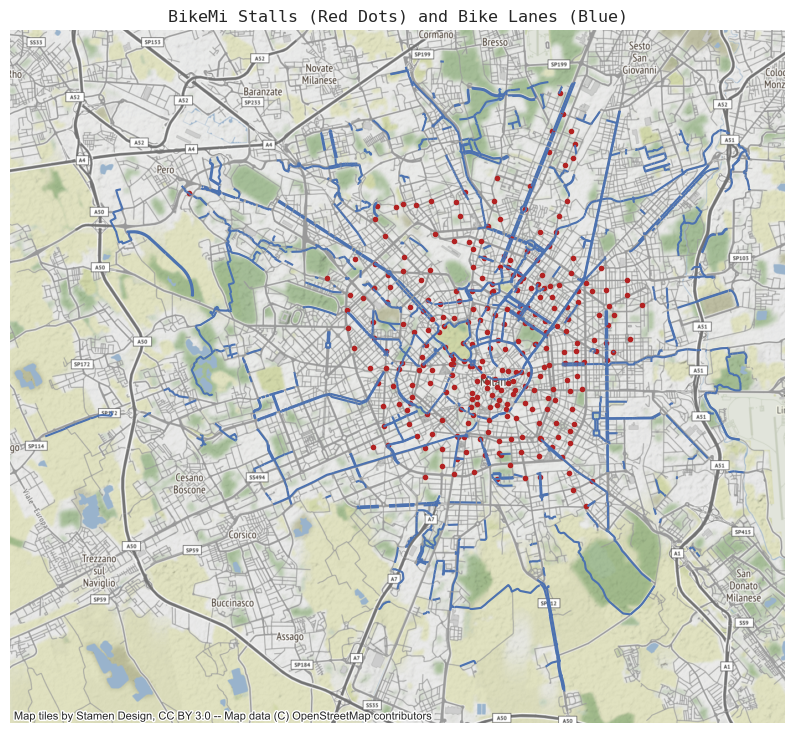

In [15]:
bike_lanes = geopandas.read_file(Path(milan_data / "transports-bike_lanes.geo.json"))

bikes_dict = {"color": "firebrick", "marker": "."}

def plot_stalls_and_bikelanes():
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    bikemi_stalls.to_crs(3857).plot(ax=ax, **bikes_dict)
    bike_lanes.to_crs(3857).plot(ax=ax)
    cx.add_basemap(ax)

    plt.axis("off")

    plt.title("BikeMi Stalls (Red Dots) and Bike Lanes (Blue)", **title_font)

    plt.show()

plot_stalls_and_bikelanes()

### Inspecting Stations with Zero Daily Rentals

The stalls in the outer stations are not as used as the ones in the city centre, which come up as an abundance of zeros in the data aggregated at daily and hourly level. Some of these stations are practically unused. Besides, the great count of stations would represent a problem in the context of multivariate regressions (the so-called $p > n$ problem). Hence, we can drop the unused stations from our data to help us reduce the dimensionality.

We start by creating another two `materialised views` with the daily and hourly rentals, by station. Since the service is only active between 7 and 24, we just keep hourly observations within that time span. If we simply were to `GROUP BY` station names and time units, we would obtain series with gaps in the time index. We first create a table with all possible combinations of stations and dates using a `CROSS JOIN` and a common table expression (or `CTE`), then left join on this table the values obtained via the `GROUP BY` on the reference table. A similar query is used to obtain the hourly rentals, with hourly time intervals instead of daily ones.

```python
def create_rentals_materialized_views(connection) -> None:
    
    query_daily_rentals: str = """
        CREATE MATERIALIZED VIEW IF NOT EXISTS bikemi_rentals.daily_rentals_before_2019 AS
        (
        WITH cross_table AS (
            SELECT d.date AS data_partenza,
                   s.nome AS stazione_partenza,
                   s.numero_stazione
            FROM (
                     SELECT *
                     FROM bikemi_rentals.bikemi_stations
                     WHERE anno < 2019
                 ) s
                     CROSS JOIN (
                SELECT generate_series(
                               timestamp '2015-06-01',
                               timestamp '2018-06-01',
                               interval '1 day'
                           )::date
            ) d(date)
            ORDER BY nome,
                     date
        )
        SELECT c.data_partenza,
               c.stazione_partenza,
               c.numero_stazione,
               COUNT(b.*)::smallint AS noleggi_giornalieri
        FROM cross_table c
                 LEFT JOIN bikemi_rentals.bikemi_rentals_before_2019 b ON b.numero_stazione_prelievo = c.numero_stazione
            AND DATE_TRUNC('day', b.data_prelievo)::date = c.data_partenza
        GROUP BY c.data_partenza,
                 c.stazione_partenza,
                 c.numero_stazione
        ORDER BY stazione_partenza,
                 data_partenza
            );
    """
    
    query_hourly_rentals: str = """
    CREATE MATERIALIZED VIEW IF NOT EXISTS bikemi_rentals.hourly_rentals_before_2019 AS
    (
    WITH cross_table AS (
        SELECT d.date_time AS data_partenza,
               s.nome      AS stazione_partenza,
               s.numero_stazione
        FROM (
                 SELECT *
                 FROM bikemi_rentals.bikemi_stations
                 WHERE anno < 2019
             ) s
                 CROSS JOIN (
            SELECT generate_series(
                           timestamp '2015-06-01',
                           timestamp '2018-06-01',
                           interval '1 hour'
                       )::timestamp
        ) d(date_time)
        WHERE EXTRACT(
                      'hour'
                      FROM d.date_time
                  ) BETWEEN 7 and 24
        ORDER BY nome,
                 date_time
    )
    SELECT c.data_partenza,
           c.stazione_partenza,
           c.numero_stazione,
           COUNT(b.*)::smallint AS noleggi_per_ora
    FROM cross_table c
             LEFT JOIN bikemi_rentals.bikemi_rentals_before_2019 b ON b.numero_stazione_prelievo = c.numero_stazione
        AND DATE_TRUNC('hour', b.data_prelievo)::timestamp = c.data_partenza
    GROUP BY c.data_partenza,
             c.stazione_partenza,
             c.numero_stazione
    ORDER BY stazione_partenza,
             data_partenza
        );
    """
    
    with connection:
        with connection.cursor() as cursor:
            cursor.execute(query_daily_rentals)
            cursor.execute(query_hourly_rentals)
```

In [16]:
def retrieve_daily_rentals(connection) -> pd.DataFrame:
    query = """
        SELECT * FROM daily_rentals_before_2019;
    """
    return pd.read_sql(query, connection).set_index("data_partenza")

daily_rentals = retrieve_daily_rentals(conn)

Then, we compute the number of null values in the data (`null_obs`), pivot the table to wider format and compute the percentage of missing values in each station (`null_obs`). Using Pandas"`cut()` method, we can convert this numerical column into a categorical variable (`null_obs_ranking`) and choose the number of levels - five, in our case - to split the column into even intervals with.

In [17]:
obs_number = daily_rentals.index.unique().shape[0]

stations_missing_obs = (
    daily_rentals[[col for col in daily_rentals.columns if "numero_stazione" not in col]]
        .pivot(columns="stazione_partenza")
        .replace(0, np.nan)
        .isna().sum()
        .sort_values(ascending=False)
        .pipe(pd.DataFrame)
        # drop the redundant index
        .droplevel(0)
        .rename({0: "null_obs"}, axis=1)
        # create the % by dividing the number of null values by the length of the datetime idnex
        .assign(pct_null=lambda x: x.null_obs / obs_number)
)

# labels for the categorical variable, assumed to be ascending order
labels = ["very_low", "low", "average", "high", "very_high"]

stations_missing_obs["null_obs_ranking"] = pd.cut(
    stations_missing_obs["pct_null"], bins=5, labels=labels
)

In this way, we can see that the number of stations with an "unacceptable" number of missing values is smaller than thirty.

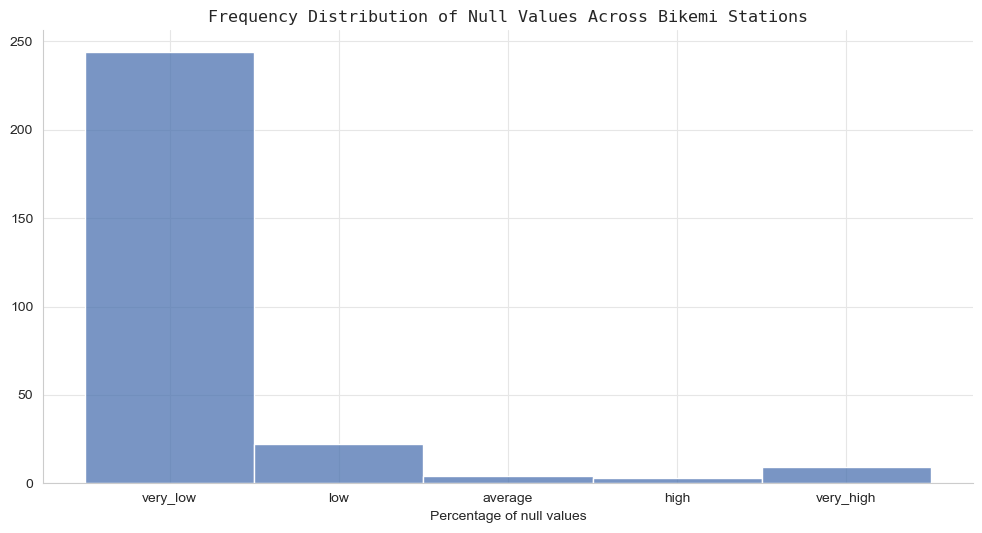

In [18]:
sns.histplot(stations_missing_obs, x="null_obs_ranking")

plt.xlabel("Percentage of null values")
plt.ylabel("")
plt.title("Frequency Distribution of Null Values Across Bikemi Stations", **title_font)

sns.despine()

plt.show()

More than 80 percent of the stations display a count of null observations inferior to 20 percent.

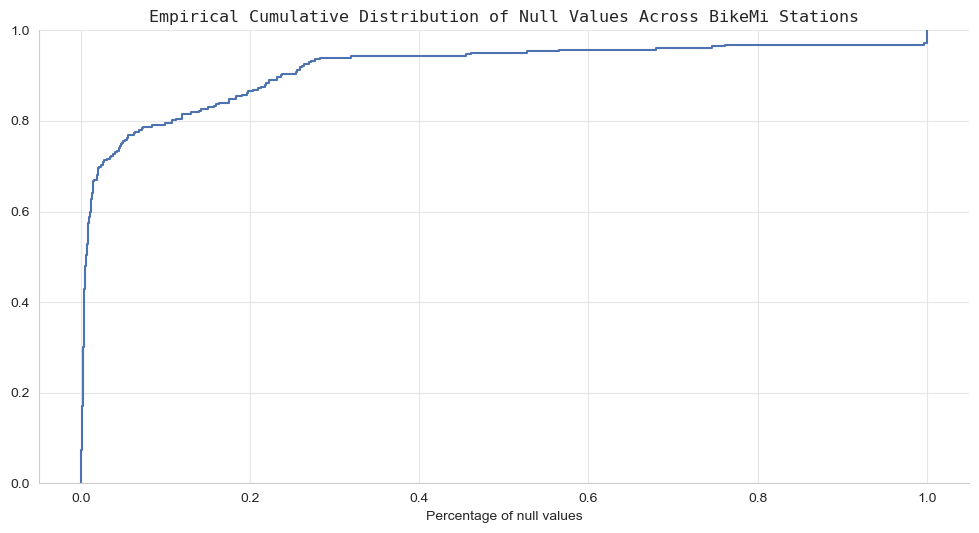

In [19]:
sns.ecdfplot(stations_missing_obs, x="pct_null")

plt.xlabel("Percentage of null values")
plt.ylabel("")
plt.title("Empirical Cumulative Distribution of Null Values Across BikeMi Stations", **title_font)

sns.despine()

plt.show()

We can also join this data with the station spatial data to plot them. While this does not expose patterns that could be used to reduce the dimensionality of the data, it shows that there are some stations that need to be dropped off even from the most crowded areas in the city. This could not be spotted before as, to the best of our knowledge, no one in the BikeMi literature has ever found a way to take into account of how public work on roads and infrastructure had effects on the bike sharing service.

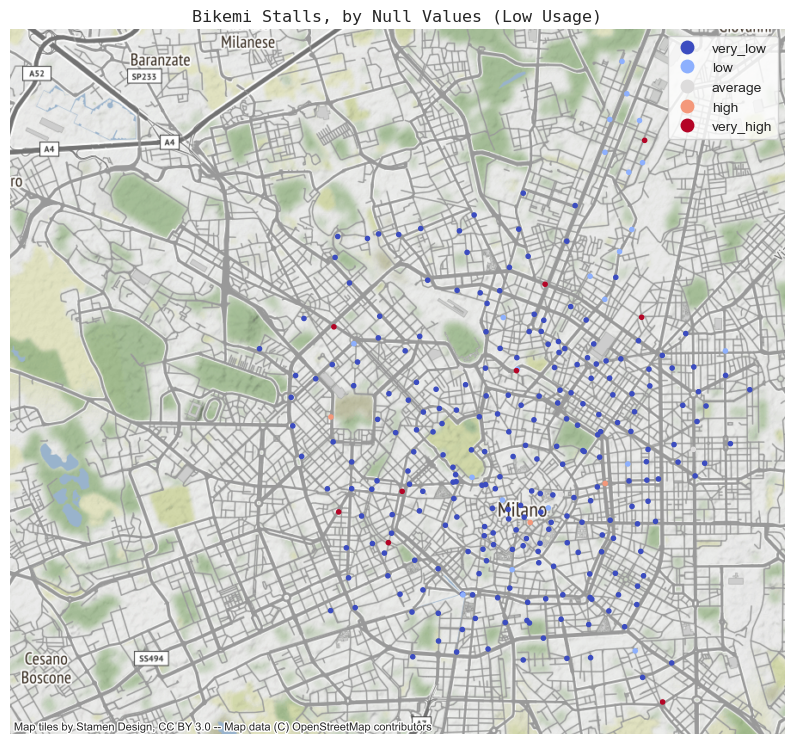

In [20]:
bikemi_stalls_nulls = (
    bikemi_stalls
        .merge(stations_missing_obs, left_on="nome", right_index=True)
)

def plot_stalls_missing_values() -> None:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    (
        bikemi_stalls_nulls
            .to_crs(3857)
            .plot(
                column="null_obs_ranking",
                cmap="coolwarm",
                marker=".",
                legend=True,
                ax=ax
        )
    )

    cx.add_basemap(ax)

    plt.axis("off")

    plt.title("Bikemi Stalls, by Null Values (Low Usage)", **title_font)

    plt.show()

plot_stalls_missing_values()

### Area of Analysis

Besides dropping the "emptiest" stations, we should also come up with a way to narrow down the geographic area inside which we perform the analysis. Previously, authors have chosen to analyse just the area inside the Bastioni, or "Area C" <cite id="sopwq">(Saibene &#38; Manzi, 2015)</cite> or the whole set of stations <cite id="srqoj">(Toro et al., 2020)</cite>. This was mainly due to the different purpose of their analysis and the data availability (Saibene and Manzi analyse data from 2008 to 2012). For our goal, as well as the policymaker perspective, this choice seems restricting, as it leaves out most of the train stations. It is worth noting that analysing the bike sharing traffic inside of Area C can be appropriate: for example, since, the municipality publishes the number of daily accesses to the area, which could be used to evaluate the effect of sharing services on traffic.

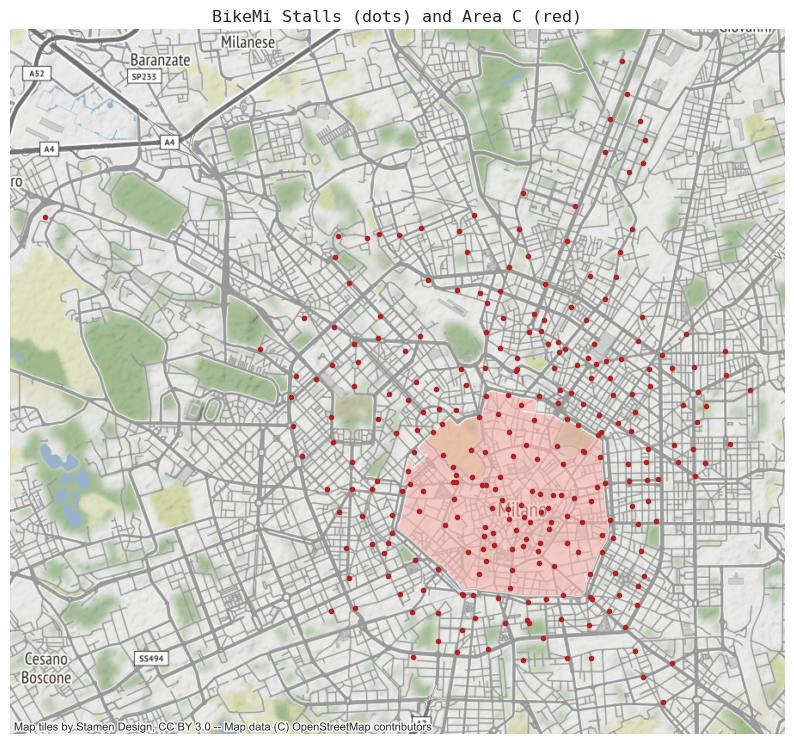

In [21]:
area_c = (
    geopandas
        .read_file(Path(milan_data / "administrative-area_c.geo.json"))
        .filter(["tipo", "geometry"])
        .query("tipo == 'AREA_C'")
)

def plot_area_c() -> None:
    fig, ax = plt.subplots(figsize=(10, 10))

    area_c.to_crs(3857).plot(ax=ax, cmap="Pastel1", alpha=0.6)
    bikemi_stalls.to_crs(3857).plot(ax=ax, **bikes_dict)
    cx.add_basemap(ax)

    plt.axis("off")

    plt.title("BikeMi Stalls (dots) and Area C (red)", **title_font)

    plt.show()

plot_area_c()

The area we propose is the road ring across Milan, informally referred to as Circonvallazione. This area encapsulates the city centre, as well as most of the train stations, and is represented by the green shade in the map below. This is arguably limiting, as the area does not take in Lambrate and Villapizzone/Bovisa train stations. However, one might argue that it is unlikely for to choose to go to Lambrate and then rent a bike to get to the city centre, as they can just get to Centrale; the same goes for the other stations. In other words, this area contains the sufficient amount of stations to provide a useful forecast for the policymaker, albeit neglecting the outer stalls.

This approach might just reinforce the bias towards the centre of the city, but given the technical constraints seems to be the more viable option. However, as a comparison, the Area C would only contain one train station, whereas this area contains all of the top rentals stalls from the origin-destination (OD) matrix.

In [22]:
metro_stations = geopandas.read_file(Path(milan_data / "transports-metro_stops.geo.json"))

# train_stations = geopandas.read_file(Path(milan_data / "transports-train_stations.zip"))
# train_stations.to_file("../data/milan/milan-transports-train_stations.geo.json", driver="GeoJSON")

train_stations = (
    geopandas
        .read_file(Path(milan_data / "transports-train_stations.geo.json"))
        .rename(str.lower, axis=1)
        .rename({"geometry": "train_geometry"}, axis=1)
        .set_geometry("train_geometry")
)

municipi = (
    geopandas
        .read_file(Path(milan_data / "administrative-municipi.geo.json"))
        .rename(str.lower, axis=1)
        .filter(["geometry", "municipio"])
        .rename({"geometry": "municipi_geometry"}, axis=1)
        .set_geometry("municipi_geometry")
)

nil = (
    geopandas
        .read_file(Path(milan_data / "administrative-nil.geo.json"))
        .rename(str.lower, axis=1)
        .filter(["id_nil", "nil", "geometry"])
        .rename({"geometry": "nil_geometry"}, axis=1)
        .set_geometry("nil_geometry")
)

milan = municipi.dissolve().rename({"municipio": "milano"}, axis=1)

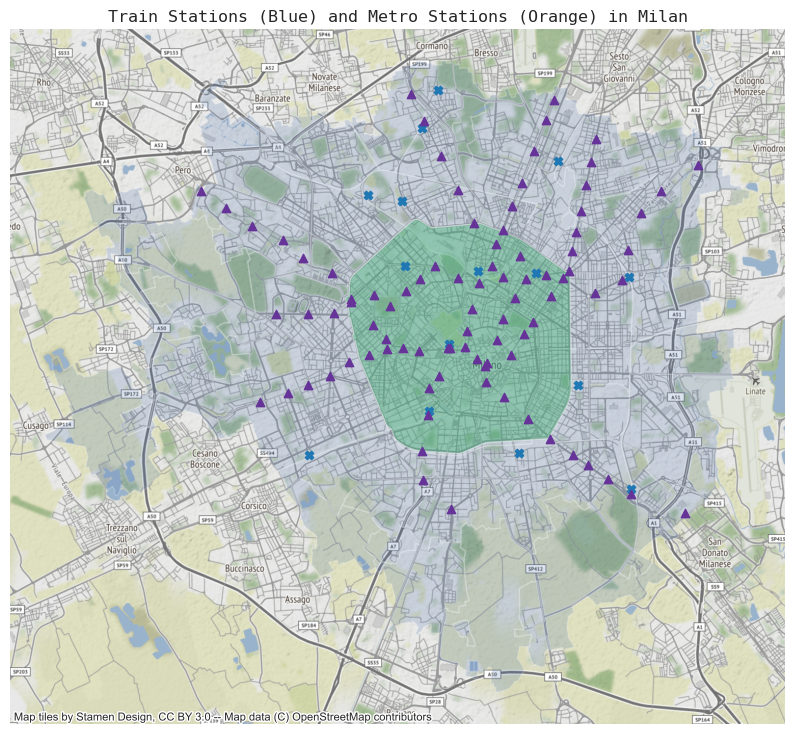

In [23]:
milan_train_stations = train_stations.to_crs(4326).sjoin(milan)
milan_metro_stations = metro_stations.sjoin(milan)

area_circonvallazione = geopandas.read_file(Path(milan_data / "custom-area_circonvallazione.geo.json"))

trains_dict = {"color": "tab:blue", "marker": "X"}
metro_dict = {"color": "rebeccapurple", "marker": "^"}


def plot_stations() -> None:

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    nil.to_crs(3857).plot(ax=ax, alpha=0.2)
    area_circonvallazione.to_crs(3857).plot(ax=ax, color="mediumseagreen", alpha=0.4)
    milan_train_stations.to_crs(3857).plot(ax=ax, **trains_dict)
    milan_metro_stations.to_crs(3857).plot(ax=ax, **metro_dict)
    cx.add_basemap(ax)

    plt.axis("off")

    plt.title("Train Stations (Blue) and Metro Stations (Orange) in Milan", **title_font)

    plt.show()


plot_stations()

This leaves us with the following stations, which we store as a `.csv` file and then upload into our local PostgreSQL database with a Bash script.

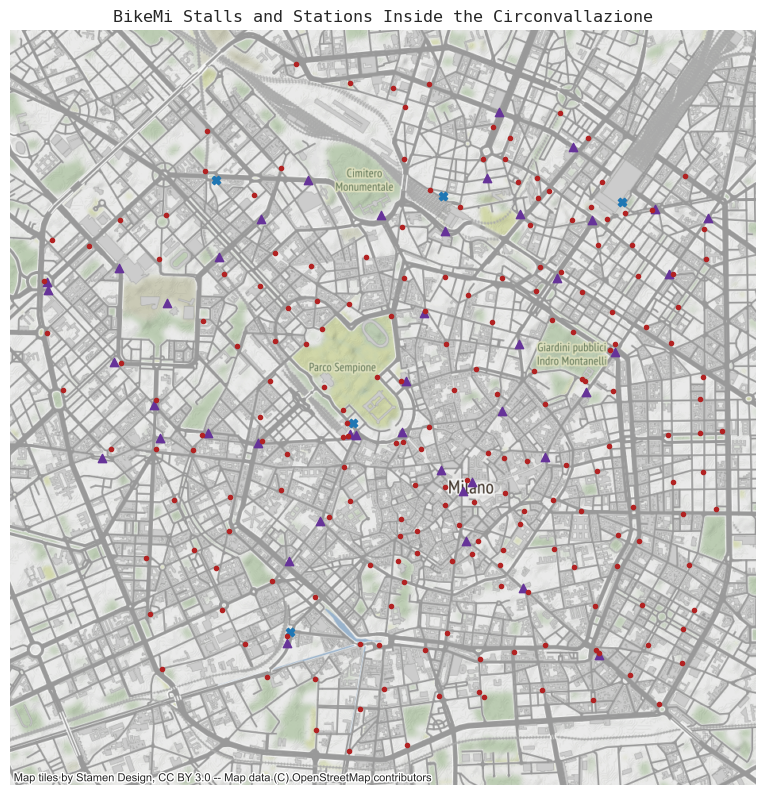

In [24]:
all_stalls: geopandas.GeoDataFrame = (
    bikemi_stalls_nulls
    .sjoin(nil)
    .sort_values("numero_stazione")
    .drop("index_right", axis=1)
    .filter(["nome", "stalls_geometry", "anno", "null_obs_ranking", "nil", "id_nil", "municipio"])
    .rename(columns={"nome": "nome_stazione"})
)

selected_stalls: geopandas.GeoDataFrame = (
    all_stalls
        .query("null_obs_ranking == 'very_low'")
        .sjoin(area_circonvallazione)
        .drop("index_right", axis=1)
)

train_stations_circ: geopandas.GeoDataFrame = (
    train_stations
        .to_crs(4326)
        .sjoin(area_circonvallazione)
        .drop("index_right", axis=1)
)

metro_stations_circ: geopandas.GeoDataFrame = (
    metro_stations
        .sjoin(area_circonvallazione)
        .drop("index_right", axis=1)
)


def plot_final_data() -> None:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    train_stations_circ.to_crs(3857).plot(ax=ax, **trains_dict)
    metro_stations_circ.to_crs(3857).plot(ax=ax, **metro_dict)
    selected_stalls.to_crs(3857).plot(ax=ax, **bikes_dict)
    cx.add_basemap(ax)

    plt.axis("off")

    plt.title("BikeMi Stalls and Stations Inside the Circonvallazione", **title_font)

    plt.show()


plot_final_data()

In [25]:
def unpack_geometry(data: geopandas.GeoDataFrame) -> pd.DataFrame:
    df = data.copy()

    df["longitudine"] = df.geometry.x
    df["latitudine"] = df.geometry.y

    return df[[col for col in df.columns if col not in "stalls_geometry"]]


# all_stalls.pipe(unpack_geometry).to_csv(milan_data / "bikemi-stalls-with_nils.csv")
selected_stalls.pipe(unpack_geometry).to_csv(milan_data / "bikemi-selected_stalls-with_nils.csv")

conn.close()